In [ ]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
development_data = pd.read_csv('../data/raw_data/country_development_data.csv')
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,hdi_2016,hdi_2017,hdi_2018,hdi_2019,gdp_2016,gdp_2017,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,0.216783,0.211268,0.208850,0.207815,0.596273,0.703846,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,0.716783,0.711268,0.709735,0.712256,0.630435,0.750000,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,0.638112,0.632042,0.628319,0.628774,0.627329,0.653846,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,0.349650,0.345070,0.338053,0.332149,0.447205,0.596154,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,0.676573,0.672535,0.674336,0.682060,0.698758,0.723077,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [ ]:
country = pd.read_csv('../data/raw_data/regression_targets.csv')
targets = country[['Country', 'Deaths', 'Confirmed', 'Active', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       6
Confirmed    6
Active       8
Recovered    6
dtype: int64


,Country,Deaths,Confirmed,Active,Recovered
0,Afghanistan,0.006186,0.142134,0.012574,0.123374
1,Albania,0.050951,2.967301,1.123714,1.792636
2,Algeria,0.006558,0.244897,0.070767,0.167572
3,Angola,0.001461,0.061687,0.003419,0.056808
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816


In [ ]:
targets.dropna(axis=0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
development_data = development_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Active', 'Recovered', 'Confirmed']
features_development = development_data.columns.drop(label_values)
features_development = features_development.drop(['Country', 'WHO code', 'FAO code'])

In [ ]:
X_development = development_data[features_development]
Y_development = development_data[label_values]

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=5, scoring=score, n_jobs=3)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv('../data/feature_selection/selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 4, 5],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250]
}

In [ ]:
xgb_development_params, xgb_development_score = hyper_parameter_search(X_development, Y_development['Deaths'], PARAMS)

[16:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {xgb_development_params}')
print(f'score: {xgb_development_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 150}
score: -0.0237749700607111


In [ ]:
xgb_development = XGBRegressor(gamma = xgb_comorbidity_params['gamma'],
                               learning_rate = xgb_comorbidity_params['learning_rate'], 
                               max_depth = xgb_comorbidity_params['max_depth'],
                               min_child_weight = xgb_comorbidity_params['min_child_weight'], 
                               n_estimators = xgb_comorbidity_params['n_estimators'],
                               random_state=0)

In [ ]:
rfecv_xgb_development = rfecv_shap_algorithm(xgb_development,
                                             X_development[X_development.columns.drop(['code'])], 
                                             Y_development['Deaths'], 
                                             'development')

In [ ]:
rfecv_xgb_development

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap development,Obesity,5,-0.011
1,rfe - measure shap development,Population,5,-0.011
2,rfe - measure shap development,Max Latitude,5,-0.011
3,rfe - measure shap development,Max Longitude,5,-0.011
4,rfe - measure shap development,Annual Average Temperature,5,-0.011


In [ ]:
X_train_development, X_test_development, Y_train_development, Y_test_development = train_test_split(
    X_development[selected_features_development],
    Y_development,
    test_size = 0.2
)

In [ ]:
xgb_development.fit(X_train_development, Y_train_development['Deaths'])

[16:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

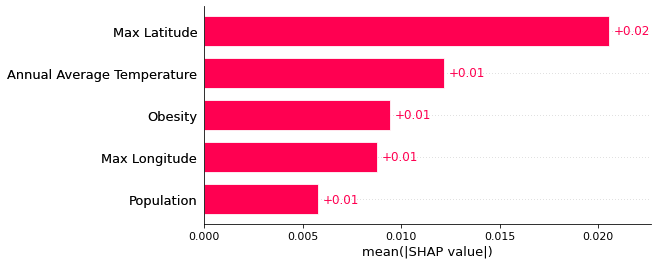

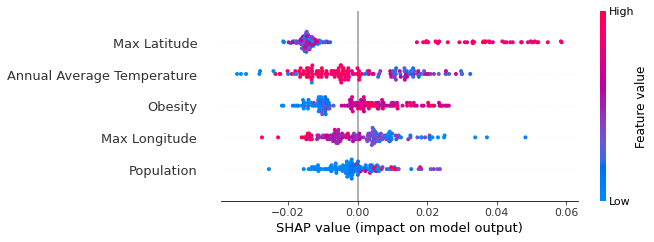

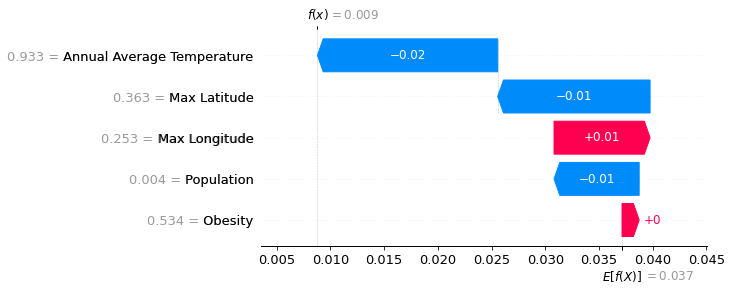

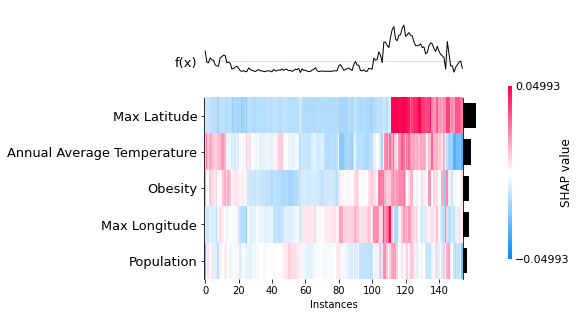

In [ ]:
expl = shap.Explainer(xgb_development, X_development[selected_features_development])
shap_values = expl(X_development[selected_features_development])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[30])
shap.plots.heatmap(shap_values)